In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from my_img_processor import My_Image
import matplotlib as mpl

In [2]:
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')

Leemos la imagen cruda

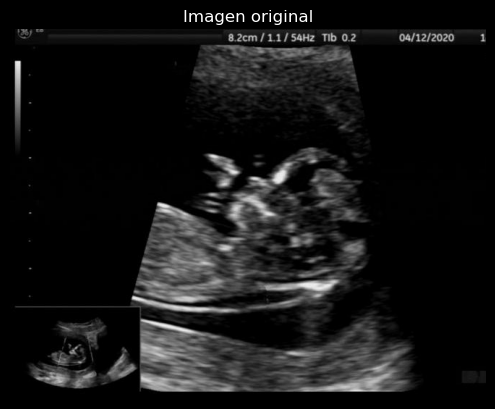

In [3]:
img_path = r'Dataset for Fetus Framework\Dataset for Fetus Framework\External Test Set\Standard\1383.png'
raw_img = My_Image(img_path)

fig_raw, ax_raw = plt.subplots()
ax_raw.imshow(raw_img, vmin=0, vmax=255, cmap='gray')
ax_raw.set_title('Imagen original')
plt.axis('off')
plt.show()

Definimos una función para elegir el punto inicial

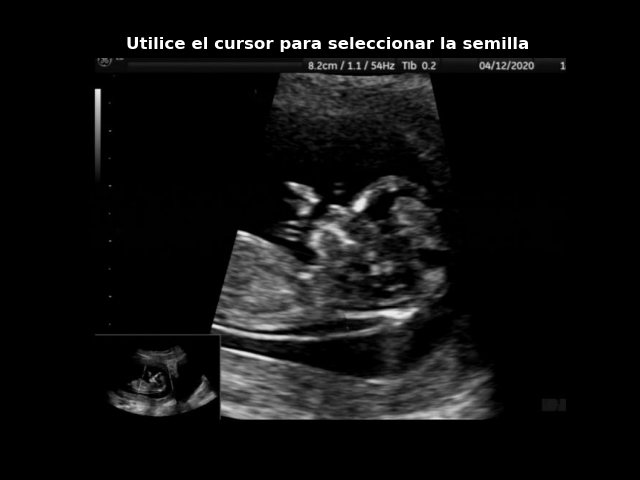

In [4]:
%matplotlib widget
x, y = 330, 370
def interactive_plot(img):
   plt.ion()
   fig, ax = plt.subplots()
   fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)
   ax.set_title('Utilice el cursor para seleccionar la semilla', fontweight='bold')
   def onclick(event):
      global x
      global y
      x = int(np.ceil(event.xdata))
      y = int(np.ceil(event.ydata))
      print(f"{x=}, {y=}")
      ax.plot(x, y, marker='x', color='yellow')
      ax.figure.canvas.draw()
      fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)

   ax.imshow(img, vmin=0, vmax=255, cmap='gray')
   plt.axis(False)
   fig.canvas.mpl_connect('button_press_event', onclick)
   plt.show()

interactive_plot(raw_img)

In [5]:
c = (500 - 23)/82
1/c

0.1719077568134172

In [6]:
plt.close()
%matplotlib inline

Ecualizamos el histograma

In [7]:
eq_img = raw_img.equalize_hist()

Binarizamos con el punto medio del histograma ecualizado

In [8]:
bin_img = np.zeros_like(raw_img)
THRES = 255//2
for i in range(bin_img.shape[0]):
    for j in range(bin_img.shape[1]):
        if eq_img[i, j] > THRES:
            bin_img[i, j] = 255

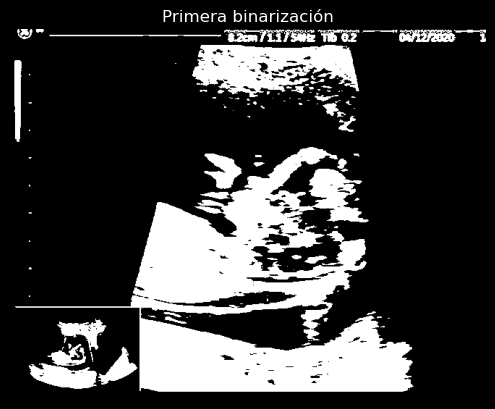

In [9]:
fig_bin, ax_bin = plt.subplots()
ax_bin.imshow(bin_img, vmin=0, vmax=255, cmap='gray')
ax_bin.set_title('Primera binarización')
plt.axis(False)
plt.show()

Eliminamos el ruido de sal y pimienta que surge de esta binarización

In [10]:
sp_img = bin_img.median_filter(5)

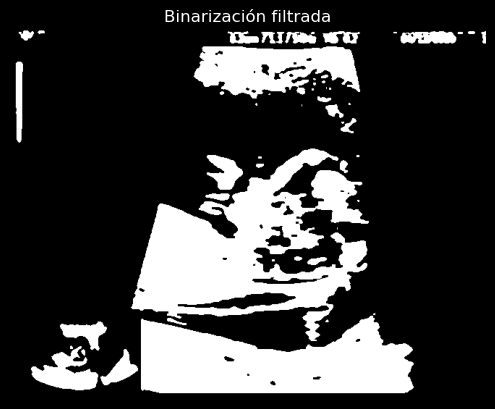

In [11]:
fig_sp, ax_sp = plt.subplots()
ax_sp.imshow(sp_img, vmin=0, vmax=255, cmap='gray')
ax_sp.set_title('Binarización filtrada')
plt.axis(False)
plt.show()

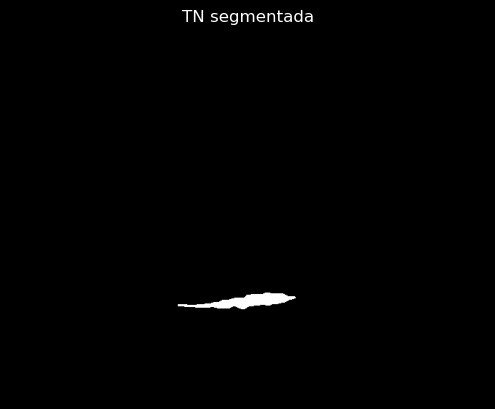

In [12]:
img_sitk = sitk.GetImageFromArray(sp_img)
img_seg = sitk.ConnectedThreshold(img_sitk, seedList=[(x, y)])
img_seg = My_Image(sitk.GetArrayFromImage(img_seg))

fig_seg, ax_seg = plt.subplots()
ax_seg.imshow(img_seg, vmin=0, vmax=1, cmap='gray')
ax_seg.set_title('TN segmentada')
plt.axis(False)
plt.show()

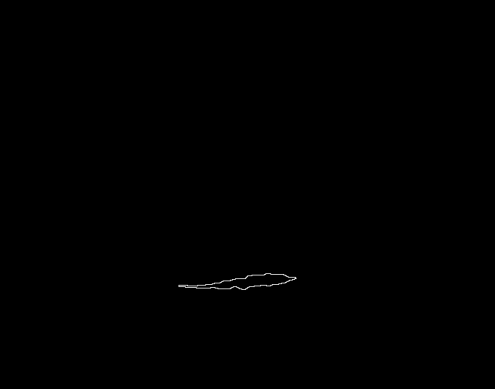

In [13]:
img_seg[img_seg > 0] = 255
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg = img_seg.filter_w_kernel(KL1)
plt.imshow(border_seg, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.show()

Extraemos los puntos del borde

Fitteamos una elipse, y con eso medimos la TN

C:\Users\gonza\Documents\ITBA\2024 1C\TP PSIB\TP_PSIB\TP PIB\my_img_processor.py:335: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = np.linalg.lstsq(A, b)[0].squeeze()


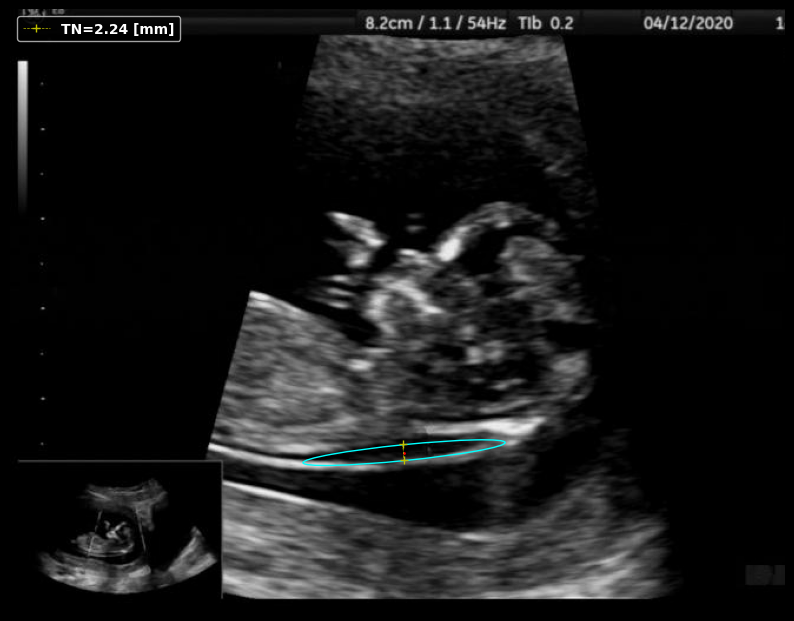

In [14]:
ellipse_patch = border_seg.fit_ellipse()
raw_img.plot_with_ellipse(ellipse_patch, c)